In the other notebook I documented how I merged the tables from several PDFs in order to have a reasonable dataframe available. At this point I continue to work with the self-created csv file.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

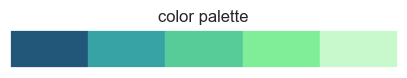

In [2]:
sns.set()

c_pal = ["#22577a","#38a3a5","#57cc99","#80ed99","#c7f9cc"]

fig, ax = plt.subplots(figsize=(5, 0.5))

for i, color in enumerate(c_pal):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(c_pal))
ax.set_ylim(0, 1)

ax.set_xticks([])
ax.set_yticks([])

plt.title('color palette')

plt.show();

In [3]:
data = pd.read_csv('data/plaenterwaldlauf.csv')

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.head()

,Startnr.,AK,Platz AK,Verein,Bruttozeit,Nettozeit,Strecke
0,605,M 20,1,TuS Kreuzweingarten-Rheder,17:16 min,(17:15),5
1,666,M 40,1,LG Mauerweg Berlin e.V.,17:56 min,(17:55),5
2,1083,M 30,1,BSV Friesen,18:07 min,(18:05),5
3,643,M 20,2,TuS Neukölln Berlin,18:12 min,(17:55),5
4,601,M 35,1,TVB 09,18:43 min,(18:27),5


Let's change the column names to English!

In [6]:
data = data.rename(columns=dict(zip(data.columns, ['Bib_number', 'Age_group', 'Ranking_age_group', 'Club', 'Gross_time', 'Net_time', 'Distance'])))

And now let's try to get an overview of the data.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Bib_number         687 non-null    int64 
 1   Age_group          687 non-null    object
 2   Ranking_age_group  687 non-null    int64 
 3   Club               674 non-null    object
 4   Gross_time         687 non-null    object
 5   Net_time           687 non-null    object
 6   Distance           687 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 37.7+ KB


In [8]:
data.shape

(687, 7)

In [9]:
missing = pd.DataFrame(data.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/data.shape[0])*100, 2)
missing

,Amount,Percentage
Bib_number,0,0.00
Age_group,0,0.00
Ranking_age_group,0,0.00
Club,13,1.89
Gross_time,0,0.00
Net_time,0,0.00
Distance,0,0.00


There are a couple of values missing in the Club column.

In [10]:
data.nunique()

Bib_number           687
Age_group             37
Ranking_age_group     32
Club                 203
Gross_time           632
Net_time             625
Distance               4
dtype: int64

Since I'm the one who created this data set by the sweat of my brow, I already know what small changes I want to make before I start the analysis.

I would like to split the Age_goup column in order to have separate columns for age group and gender.

In [11]:
data['Age_group'].unique()

array(['M 20', 'M 40', 'M 30', 'M 35', 'W 35', 'MJ U20', 'M 45', 'MJ U16',
       'W 20', 'W 30', 'MK U12', 'W 50', 'M 50', 'W 40', 'M 65', 'WK U12',
       'M 55', 'WJ U16', 'MJ U18', 'W 55', 'MK U10', 'MJ U14', 'W 60',
       'WJ U14', 'M 60', 'W 65', 'W 45', 'WK U10', 'M 70', 'M 75', 'W 70',
       'W20', 'WJ U18', 'M 85', 'M 80', 'W 85', 'M40'], dtype=object)

These are the age groups. M 20 means "Männer" (men) 20-24 years old, W 35 "Frauen" (Women) 35-39 years old. MJ U18 means "männliche Jugend" (male youth) under 18 (= 16 or 17 years old), WK U10 "weibliche Kinder" (female children) under 10 (8 or 9 years old)... and so on.

We should separate the first part of the abbreviation from the second part. But let's fix the "M40" and "W20"
first to have it all in the same format (with space):

In [12]:
data['Age_group'] = data['Age_group'].str.replace('M40', 'M 40')
data['Age_group'] = data['Age_group'].str.replace('W20', 'W 20')

In [13]:
data['Age_group'].unique()

array(['M 20', 'M 40', 'M 30', 'M 35', 'W 35', 'MJ U20', 'M 45', 'MJ U16',
       'W 20', 'W 30', 'MK U12', 'W 50', 'M 50', 'W 40', 'M 65', 'WK U12',
       'M 55', 'WJ U16', 'MJ U18', 'W 55', 'MK U10', 'MJ U14', 'W 60',
       'WJ U14', 'M 60', 'W 65', 'W 45', 'WK U10', 'M 70', 'M 75', 'W 70',
       'WJ U18', 'M 85', 'M 80', 'W 85'], dtype=object)

Good. Now we have to split the values exactly where the space is. And then only keep the M or W (and change to M and F - english) in the Gender column. 

In [14]:
data[['Gender', 'Age']] = data['Age_group'].str.split(' ', expand=True)
data['Gender'] = data['Gender'].str.replace(r'(?i)(W|M).', r'\1', regex=True)
data['Gender'] = data['Gender'].replace('W', 'F')

For the ages we need a dictionary:

In [15]:
data['Age'].unique()

array(['20', '40', '30', '35', 'U20', '45', 'U16', 'U12', '50', '65',
       '55', 'U18', 'U10', 'U14', '60', '70', '75', '85', '80'],
      dtype=object)

In [16]:
age_mapping = {'20': '20-24', '40': '40-44', '30': '30-34', '35': '35-39', 'U20': '18-19', '45': '45-49', 'U16': '14-15', 'U12': '10-11', '50': '50-54', '65':'65-69', '55': '55-59', 'U18': '16-17', 'U10': '8-9', 'U14': '12-13', '60': '60-64', '70': '70-74', '75': '75-79', '85': '85-89', '80': '80-84'}

In [17]:
data['Age'] = data['Age'].replace(age_mapping)

Next, i would like to take care of the gross and net times so that they are available in the same format.

In [18]:
data['Gross_time'] = data['Gross_time'].str.replace(' min', '').str.replace(' h', '')
data['Net_time'] = data['Net_time'].apply(lambda x: x.strip('()'))
def convert_to_hh_mm_ss(time_str):
    if len(time_str.split(':')) == 2:
        time_str = '00:' + time_str
    return pd.to_timedelta(time_str)

data['Gross_time'] = data['Gross_time'].apply(convert_to_hh_mm_ss)
data['Net_time'] = data['Net_time'].apply(convert_to_hh_mm_ss)

I don't need the gross time if i want to find out who ran the fastest. The difference between gross and net time in this data set is the time that elapsed after the starting shot and before you actually crossed the starting line to start the run. In my case, for example, that was more than a minute - due to the crowd at the start.

I'll add another column that shows exactly this waiting time.

In [19]:
data['Waiting_time'] = data['Gross_time'] - data['Net_time']

The fastest 3 runners in the race positioned themselves quite well - in front of the pack. That's smart. Even if the waiting time is deducted from the race time at the end, you still have to fight your way through if you are further back. That costs time.

Next step will be to calculate the pace:

In [20]:
data['Pace'] = data['Net_time']/data['Distance']

I now have some columns with values in timedelta format. This doesn't look nice, because we don't calculate in days here. But at least it is a format in which we can calculate at all.  

I'm going to transform the pace column because it hurts my eyes to see it like this.

In [21]:
from datetime import timedelta

def convert_pace(pace_str):
    time_component = str(pace_str).split()[2]  
    
    time_parts = time_component.split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(float(time_parts[2]))
    
    formatted_pace = f"{minutes}:{seconds:02}"
    if hours > 0:
        formatted_pace = f"{hours}:{formatted_pace}"
    
    return formatted_pace

In [22]:
data['Pace'] = data['Pace'].apply(convert_pace)

In [23]:
def pace_to_time(pace_str):
    pace_time = datetime.strptime(pace_str, '%M:%S').time()
    return pace_time

In [24]:
data['Pace'] = data['Pace'].apply(pace_to_time)

In [25]:
data['Club'] = data['Club'].fillna('Berlin')

This is how the data set looks like, now after all these changes:

In [26]:
data.head(5)

,Bib_number,Age_group,Ranking_age_group,Club,Gross_time,Net_time,Distance,Gender,Age,Waiting_time,Pace
0,605,M 20,1,TuS Kreuzweingarten-Rheder,0 days 00:17:16,0 days 00:17:15,5,M,20-24,0 days 00:00:01,00:03:27
1,666,M 40,1,LG Mauerweg Berlin e.V.,0 days 00:17:56,0 days 00:17:55,5,M,40-44,0 days 00:00:01,00:03:35
2,1083,M 30,1,BSV Friesen,0 days 00:18:07,0 days 00:18:05,5,M,30-34,0 days 00:00:02,00:03:37
3,643,M 20,2,TuS Neukölln Berlin,0 days 00:18:12,0 days 00:17:55,5,M,20-24,0 days 00:00:17,00:03:35
4,601,M 35,1,TVB 09,0 days 00:18:43,0 days 00:18:27,5,M,35-39,0 days 00:00:16,00:03:41


Now let's start with the actual work: the analysis of the data! 

## Analysis

First let's see which age the participants had:

### Age

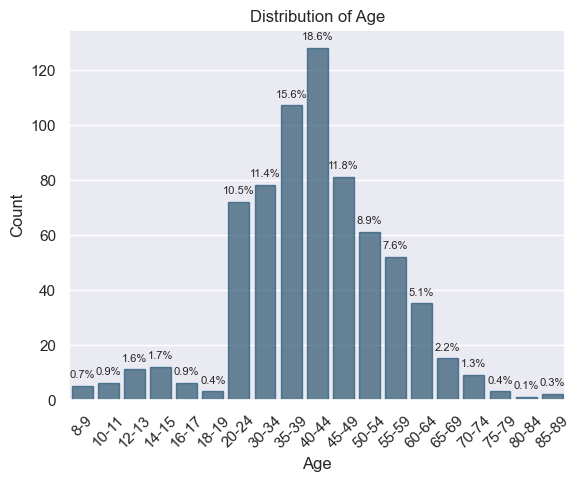

In [27]:
age_order = ['8-9','10-11','12-13','14-15','16-17','18-19','20-24','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89']

ax = sns.countplot(x='Age', data=data, color='#22577a', order=age_order,alpha=0.7,linewidth=1, edgecolor='#22577a')

total_count = len(data['Age'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=8)

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

We can see a quite symmetrical distribution with more than 50% of the participants in the age between 30 and 50.

Now we have a look at:

### Gender

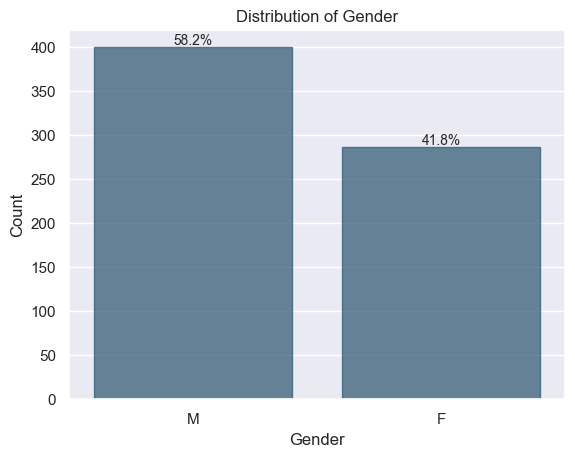

In [28]:
ax = sns.countplot(x='Gender', data=data, color='#22577a',alpha=0.7,linewidth=1, edgecolor='#22577a')

total_count = len(data['Gender'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=10)

plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

There were more men in the race.

Now let's see which distance the participants ran:

### Distance

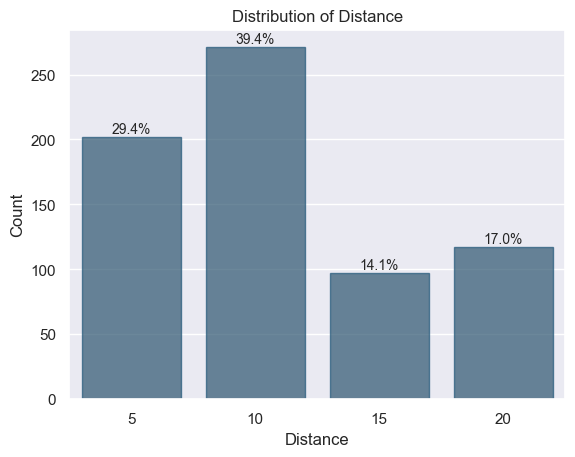

In [29]:
ax = sns.countplot(x='Distance', data=data, color='#22577a',alpha=0.7,linewidth=1, edgecolor='#22577a')

total_count = len(data['Distance'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=10)

plt.title('Distribution of Distance')
plt.xlabel('Distance')
plt.ylabel('Count')

plt.show()

Most runners participated in the 10 km race.

I now want to check whether the runners were members of a running club or not.

### Club

First I have to change the values in that column a bit. We are not interested in the name of each club, but only the question: Club yes or no.

In [30]:
def change_club_values(row):
    if row['Club'] == 'Berlin':
        return 'No Club'
    else:
        return 'Club'

In [31]:
data['Club'] = data.apply(change_club_values, axis=1)

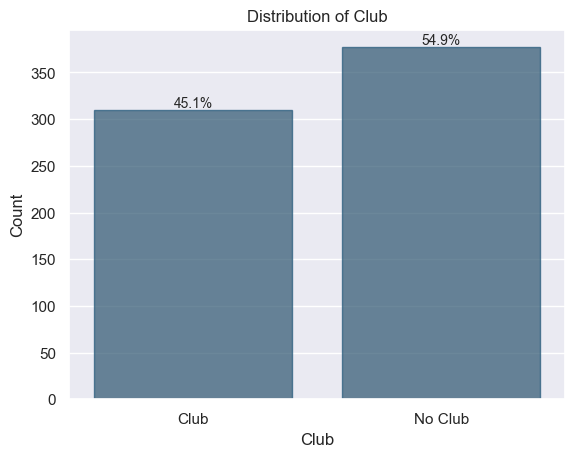

In [32]:
ax = sns.countplot(x='Club', data=data, color='#22577a',alpha=0.7,linewidth=1, edgecolor='#22577a')

total_count = len(data['Club'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=10)

plt.title('Distribution of Club')
plt.xlabel('Club')
plt.ylabel('Count')

plt.show()

The were quite a lot of participants members in a (running) club.

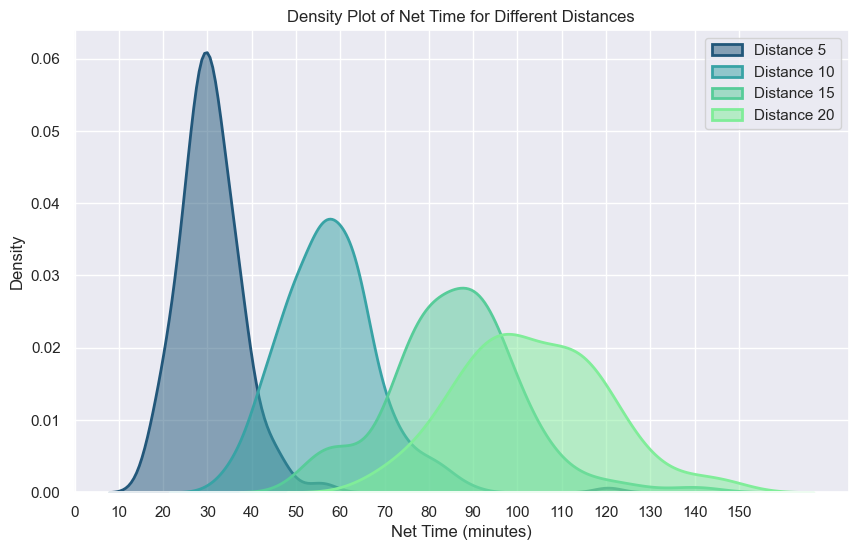

In [33]:
plt.figure(figsize=(10, 6))
distances = [5, 10, 15, 20]
colors = ["#22577a","#38a3a5","#57cc99","#80ed99"]  
for i, distance in enumerate(distances):
    filtered_df = data[data['Distance'] == distance].copy()
    filtered_df['Net_time_minutes'] = filtered_df['Net_time'].dt.total_seconds() / 60
    data.loc[data['Distance'] == distance, 'Net_time_minutes'] = filtered_df['Net_time_minutes']
    sns.kdeplot(filtered_df['Net_time_minutes'], color=colors[i], linewidth=2, fill=True, alpha=0.5, label=f'Distance {distance}')

plt.xlabel('Net Time (minutes)')
plt.ylabel('Density')
plt.title('Density Plot of Net Time for Different Distances')
plt.xticks(np.arange(0, data['Net_time_minutes'].max() + 10, 10))

plt.legend();

The shorter the distance, the more the net times are concentrated in a certain area. This is not surprising. Differences in performance (in terms of pace) are of course more noticeable over longer distances.
You can also see that the runners of the longer distances are faster overall. If we still have a clear peak for 5 km at almost exactly 30 minutes (which corresponds to a pace of 6), this shifts further and further forward as the distance increases. The pace of the participants improves as the distance increases. Only a few runners run at a pace of 6 or slower over 20 km.

In [34]:
data.columns

Index(['Bib_number', 'Age_group', 'Ranking_age_group', 'Club', 'Gross_time',
       'Net_time', 'Distance', 'Gender', 'Age', 'Waiting_time', 'Pace',
       'Net_time_minutes'],
      dtype='object')